In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("./data/PDB_31-12-2012.csv")

In [3]:
data.head()

,Unnamed: 0,pdb_id,seq,sst3,sst8
0,0,1a0gA,GYTLWNDQIVKDEEVKIDKEDRGYQFGDGVYEVVKVYNGEMFTVNE...,CEEEECCEEEEHHHCCECCCEHHHHHCCEEEEEEEEECCEECCHHH...,CEEEETTEEEEGGGCCBCTTBHHHHHCCEEEEEEEEETTEETTHHH...
1,1,1a27A,ARTVVLITGCSSGIGLHLAVRLASDPSQSFKVYATLRDLKTQGRLW...,CCEEEEECCCCCHHHHHHHHHHHCCCCCCEEEEEEECCHHHCHHHH...,CCEEEEESCCSSHHHHHHHHHHHTCTTCCEEEEEEESSGGGTHHHH...
2,2,1a34A,TGDNSNVVTMIRAGSYPKVNPTPTWVRAIPFEVSVQSGIAFKVPVG...,CCCCCCCCCCCCCCCCCCCCCCCCEEEEEEEEEECCCCCCEEEEHH...,CCCSCCSCCCCCCCSCCCCCSSCCEEEEEEEEEECCTTCCEEEEGG...
3,3,1a3aA,LFKLGAENIFLGRKAATKEEAIRFAGEQLVKGGYVEPEYVQAMLDR...,CCCCCHHHEECCCCCCCHHHHHHHHHHHHHHCCCECCHHHHHHHHH...,CCCCCGGGEECSCCCSSHHHHHHHHHHHHHHTTSBCTHHHHHHHHH...
4,4,1a3cA,QKAVILDEQAIRRALTRIAHEMIERNKCILVGIKTRGIYLAKRLAE...,CEEEEECHHHHHHHHHHHHHHHHHHCCCEEEEECHHHHHHHHHHHH...,CEEEEECHHHHHHHHHHHHHHHHHHCCCEEEEESHHHHHHHHHHHH...


In [4]:
data.drop(columns=["sst8"])

,Unnamed: 0,pdb_id,seq,sst3
0,0,1a0gA,GYTLWNDQIVKDEEVKIDKEDRGYQFGDGVYEVVKVYNGEMFTVNE...,CEEEECCEEEEHHHCCECCCEHHHHHCCEEEEEEEEECCEECCHHH...
1,1,1a27A,ARTVVLITGCSSGIGLHLAVRLASDPSQSFKVYATLRDLKTQGRLW...,CCEEEEECCCCCHHHHHHHHHHHCCCCCCEEEEEEECCHHHCHHHH...
2,2,1a34A,TGDNSNVVTMIRAGSYPKVNPTPTWVRAIPFEVSVQSGIAFKVPVG...,CCCCCCCCCCCCCCCCCCCCCCCCEEEEEEEEEECCCCCCEEEEHH...
3,3,1a3aA,LFKLGAENIFLGRKAATKEEAIRFAGEQLVKGGYVEPEYVQAMLDR...,CCCCCHHHEECCCCCCCHHHHHHHHHHHHHHCCCECCHHHHHHHHH...
4,4,1a3cA,QKAVILDEQAIRRALTRIAHEMIERNKCILVGIKTRGIYLAKRLAE...,CEEEEECHHHHHHHHHHHHHHHHHHCCCEEEEECHHHHHHHHHHHH...
...,...,...,...,...
5872,5872,4i4kA,STDSITSAPDAALAAVAALPARIVAAWADHDADRFADVFAEDGTXI...,CCCCCCCHHHHHHHHHHCHHHHHHHHHHCCCHHHHHCCEEEEEEEE...
5873,5873,4i62A,IEAIKSKGKLVVALNPDFAPFEYQKVVDGKNQIVGSDIELAKAIAT...,CHHHHHHCEEEEEECCCECCCEEEEEECCEEEEECHHHHHHHHHHH...
5874,5874,4i8eX,RAVTESAPNVEYHDVKGDMIQSVTTSFDDTSRLLTWTINLTPRQVK...,CCEEEECCEEEEECCCCCCEEEEEEEEECCCCEEEEEEEECCCCCC...
5875,5875,4id9A,MILVTGSAGRVGRAVVAALRTQGRTVRGFDLRPSGTGGEEVVGSLE...,CEEEECCCCHHHHHHHHHHHHCCCCEEEEECCCCCCCCCEEECCCC...


In [5]:
amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
aa_dict = {aa: i for i, aa in enumerate(amino_acids)}
ss3_dict = {'H': 0, 'E': 1, 'C': 2}

window_size = 17
half_window = window_size // 2

X = []
y = []

for idx, row in data.iterrows():
    seq = row['seq']
    label = row['sst3']
    
    # Pad sequence
    padded_seq = 'X' * half_window + seq + 'X' * half_window
    
    for i in range(len(seq)):
        window = padded_seq[i:i+window_size]
        window_vec = []
        
        for aa in window:
            vec = np.zeros(20)
            if aa in aa_dict:
                vec[aa_dict[aa]] = 1
            # else: leave as zeros for 'X' or unknown
            window_vec.extend(vec)  # Flatten for traditional ML
            
        X.append(window_vec)
        y.append(ss3_dict[label[i]])

X = np.array(X)
y = np.array(y)

print(f"Feature shape: {X.shape}, Labels shape: {y.shape}")

Feature shape: (1378143, 340), Labels shape: (1378143,)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [7]:
xgb_model = XGBClassifier(
    n_estimators=500,
    max_depth=7,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softmax',
    num_class=3,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

xgb_model.fit(X_train, y_train)

c:\Users\samuel.olubunmi\fola\venv\lib\site-packages\xgboost\training.py:183: UserWarning: [15:16:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None, num_class=3, ...)

In [8]:
y_pred = xgb_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=["H", "E", "C"]))

Accuracy: 0.6420623374173254

Classification Report:
               precision    recall  f1-score   support

           H       0.64      0.70      0.67    100152
           E       0.63      0.46      0.53     66532
           C       0.65      0.70      0.67    108945

    accuracy                           0.64    275629
   macro avg       0.64      0.62      0.62    275629
weighted avg       0.64      0.64      0.64    275629



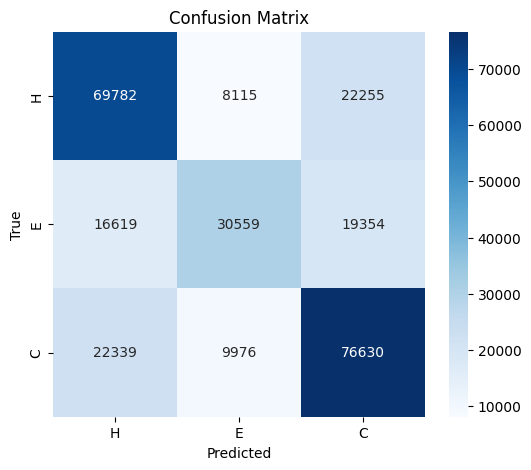

In [9]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["H", "E", "C"], yticklabels=["H", "E", "C"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [10]:
joblib.dump(xgb_model, "protein_ss_xgb_model.pkl")

['protein_ss_xgb_model.pkl']